In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
# Load data
df_model_HDP = pd.read_csv('/mnt/data/2020_Projects/2021_HDP/03_Data/FBCcalc_simbio_fastfield_20subj/newdata4/df_model_HDP.csv')
df_model_CST = pd.read_csv('/mnt/data/2020_Projects/2021_HDP/03_Data/FBCcalc_simbio_fastfield_20subj/newdata4/df_model_CST.csv')

clinical_HDP_all = pd.read_csv('/mnt/data/2020_Projects/2021_HDP/03_Data/FBCcalc_simbio_fastfield_20subj/clinical_mA_effect.csv')
clinical_CST_all = pd.read_csv('/mnt/data/2020_Projects/2021_HDP/03_Data/FBCcalc_simbio_fastfield_20subj/clinical_mA_side_effect_capsular.csv')

In [3]:
# clinical_mA_side_effect_capsular.csv contains nan in 'mA_capsular' for those contacts that result in non-capsular side effects
clinical_CST_all = clinical_CST_all.dropna()
clinical_CST_all.drop('mA', axis=1, inplace=True)

In [6]:
# keep only tested contacts, where mA ~= 0
clinical_HDP = clinical_HDP_all[(clinical_HDP_all['mA'] > 0) & (clinical_HDP_all['mA'] < 8)]
clinical_CST = clinical_CST_all[(clinical_CST_all['mA_capsular'] > 0) & (clinical_CST_all['mA_capsular'] < 8)]

#clinical_HDP = clinical_HDP_all[(clinical_HDP_all['mA'] > 0)]
#clinical_CST = clinical_CST_all[(clinical_CST_all['mA_capsular'] > 0)]

In [7]:
# select best contact from df_model
# model_pred == 1
df_model1_HDP = df_model_HDP[(df_model_HDP['model_pred'] == 1)]
df_model1_CST = df_model_CST[(df_model_CST['model_pred'] == 1)]

# contact with smallest mA
best_contact_HDP = df_model1_HDP.groupby(['LeadID', 'ContactID'], as_index=False).mA.min()
best_contact_HDP.rename(columns={'mA': 'mA_model'}, inplace=True)  #rename column

best_contact_CST = df_model1_CST.groupby(['LeadID', 'ContactID'], as_index=False).mA.min()
best_contact_CST.rename(columns={'mA': 'mA_model'}, inplace=True)

# filter contacts in best_contact to keep only those present in clinical_mA
df_clinical_model_CST = pd.merge(clinical_CST, best_contact_CST, how="left", on=['LeadID', 'ContactID'])
df_clinical_model_HDP = pd.merge(clinical_HDP, best_contact_HDP, how="left", on=['LeadID', 'ContactID'])

# CST --> there are some contacts for which there are side effects in clinical but the model predicts no side effects -> it's possible that these are non capsular side effects. For now, remove the contacts for which df_clinical_model['mA_model'] == nan
df_clinical_model_CST = df_clinical_model_CST.dropna()

In [12]:
# replace patient initials for ID number
# as CST contains all the leads (ID), create dict from here
names = pd.unique(df_clinical_model_CST.LeadID.ravel())
names = pd.Series(np.arange(len(names)), names) + 1

df_clinical_model_CST['ID'] = ''
df_clinical_model_CST['ID'] = df_clinical_model_CST.applymap(names.get)

#df_clinical_model_HDP.insert(loc=0, column ='ID', value='')
df_clinical_model_HDP['ID'] = ''
df_clinical_model_HDP['ID'] = df_clinical_model_HDP.applymap(names.get)

## HDP

In [13]:
# error diff
df_clinical_model_HDP['mA_diff'] = df_clinical_model_HDP['mA_model'] - df_clinical_model_HDP['mA']
df_clinical_model_HDP['mA_diff_abs'] = abs(df_clinical_model_HDP['mA_model'] - df_clinical_model_HDP['mA'])

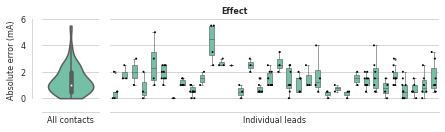

In [14]:
yticks = np.arange(0,7,2)

sns.set_style("whitegrid")
plt.rc('font', size=8)

fig = plt.figure()
fig.set_figheight(3.35)
fig.set_figwidth(7.1)
fig.suptitle('Effect', fontweight='heavy', fontsize=8, y=0.93)

ax1 = plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(2, 6), loc=(0, 1), colspan=5)

sns.set_style("whitegrid")
plt.rc('font', size=8)

sns.violinplot(data=df_clinical_model_HDP.mA_diff_abs, color='mediumaquamarine', cut=0, scale='count', ax=ax1)

ax1.set_xlabel('All contacts')
ax1.set_ylabel('Absolute error (mA)')
ax1.set_yticks(yticks)
ax1.set_xticks([])

sns.boxplot(x="ID", y="mA_diff_abs", data=df_clinical_model_HDP, color='mediumaquamarine', width=0.5, linewidth=0.6, fliersize=1.5, ax=ax2)
sns.stripplot(x="ID", y="mA_diff_abs", data=df_clinical_model_HDP, color="black", jitter=0.25, size=2, ax=ax2)

ax2.set_xlabel('Individual leads')
ax2.set_ylabel('')
ax2.set_xticks([])
ax2.set_yticks(yticks, labels='')

sns.despine(offset=10, trim=True, ax=ax1)
sns.despine(offset=10, left=True, ax=ax2)

plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/th_HDP.png', dpi=300, bbox_inches='tight')

In [15]:
df_clinical_model_HDP.mA_diff_abs.mean()

1.3658536585365855

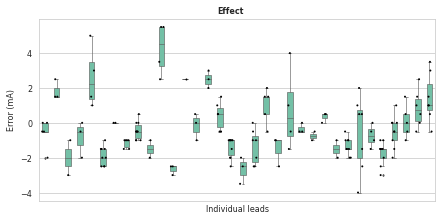

In [16]:
#yticks = np.arange(-5,6,2)

sns.set_style("whitegrid")
plt.rc('font', size=8)

fig = plt.figure()
fig.set_figheight(3.35)
fig.set_figwidth(7.1)
fig.suptitle('Effect', fontweight='heavy', fontsize=8, y=0.93)

#ax1 = plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(1, 6), loc=(0, 0), colspan=6)


sns.boxplot(x="ID", y="mA_diff", data=df_clinical_model_HDP, color='mediumaquamarine', width=0.5, linewidth=0.6, fliersize=1.5, ax=ax2)
sns.stripplot(x="ID", y="mA_diff", data=df_clinical_model_HDP, color="black", jitter=0.25, size=2, ax=ax2)

ax2.set_xlabel('Individual leads')
ax2.set_ylabel('Error (mA)')
ax2.set_xticks([])
#ax2.set_yticks(yticks)

#sns.despine(offset=10, trim=True, ax=ax1)
#sns.despine(offset=10, left=True, ax=ax2)

plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/th_HDP_signed.png', dpi=300, bbox_inches='tight')

## CST

In [17]:
# error diff
df_clinical_model_CST.rename(columns={'mA_capsular': 'mA'}, inplace=True)
df_clinical_model_CST['mA_diff'] = df_clinical_model_CST['mA_model'] - df_clinical_model_CST['mA']
df_clinical_model_CST['mA_diff_abs'] = abs(df_clinical_model_CST['mA_model'] - df_clinical_model_CST['mA'])

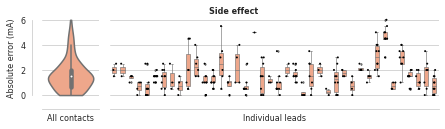

In [18]:
yticks = np.arange(0,7,2)

sns.set_style("whitegrid")
plt.rc('font', size=8)

fig = plt.figure()
fig.set_figheight(3.35)
fig.set_figwidth(7.1)
fig.suptitle('Side effect', fontweight='heavy', fontsize=8, y=0.92,)

ax1 = plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(2, 6), loc=(0, 1), colspan=5)

sns.set_style("whitegrid")
plt.rc('font', size=8)

sns.violinplot(data=df_clinical_model_CST.mA_diff_abs, color='lightsalmon', cut=0, scale='count', ax=ax1)

ax1.set_xlabel('All contacts')
ax1.set_ylabel('Absolute error (mA)')
ax1.set_yticks(yticks)
ax1.set_xticks([])

sns.boxplot(x="ID", y="mA_diff_abs", data=df_clinical_model_CST, color='lightsalmon', width=0.5, linewidth=0.6, fliersize=1.5, ax=ax2)
sns.stripplot(x="ID", y="mA_diff_abs", data=df_clinical_model_CST, color="black", jitter=0.25, size=2, ax=ax2)

ax2.set_xlabel('Individual leads')
ax2.set_ylabel('')
ax2.set_xticks([])
ax2.set_yticks(yticks, labels='')

sns.despine(offset=10, trim=True, ax=ax1)
sns.despine(offset=10, left=True, ax=ax2)

plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/th_CST.png', dpi=300, bbox_inches='tight')

In [19]:
df_clinical_model_CST.mA_diff_abs.median()

1.5

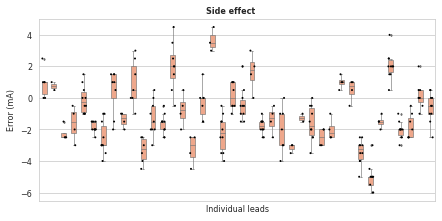

In [27]:
#yticks = np.arange(-5,6,2)

sns.set_style("whitegrid")
plt.rc('font', size=8)

fig = plt.figure()
fig.set_figheight(3.35)
fig.set_figwidth(7.1)
fig.suptitle('Side effect', fontweight='heavy', fontsize=8, y=0.93)

#ax1 = plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(1, 6), loc=(0, 0), colspan=6)


sns.boxplot(x="ID", y="mA_diff", data=df_clinical_model_CST, color='lightsalmon', width=0.5, linewidth=0.6, fliersize=1.5, ax=ax2)
sns.stripplot(x="ID", y="mA_diff", data=df_clinical_model_CST, color="black", jitter=0.25, size=2, ax=ax2)

ax2.set_xlabel('Individual leads')
ax2.set_ylabel('Error (mA)')
ax2.set_xticks([])
#ax2.set_yticks(yticks)

#sns.despine(offset=10, trim=True, ax=ax1)
#sns.despine(offset=10, left=True, ax=ax2)

plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/th_CST_signed.png', dpi=300, bbox_inches='tight')

#### Repeated measures correlation

/home/alba/PycharmProjects/HDP/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


               r  dof     pval          CI95%    power
rm_corr  0.15277  130  0.08033  [-0.02, 0.32]  0.41867


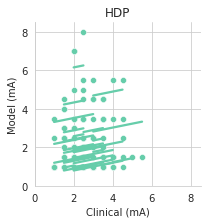

In [13]:
# HDP
import pingouin as pg

rm = pg.rm_corr(data=df_clinical_model_HDP, x='mA', y='mA_model', subject='ID')
print(rm)

palette = sns.color_palette(['mediumaquamarine'])

plt.rc('font', size=10)
g = pg.plot_rm_corr(data=df_clinical_model_HDP, x='mA', y='mA_model', subject='ID', kwargs_facetgrid=dict(palette=palette))

plt.xlim([0, 8.5])
plt.ylim([0, 8.5])

plt.xlabel('Clinical (mA)')
plt.ylabel('Model (mA)')
plt.title('HDP')
#plt.legend(title='Lead', bbox_to_anchor=(1.05, 2), loc='upper left', borderaxespad=0)

plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/rm_corr_HDP.png', dpi=300, bbox_inches='tight')

In [14]:
# Pearson
import scipy.stats as stats
r = stats.pearsonr(df_clinical_model_HDP['mA'], df_clinical_model_HDP['mA_model'])
print(r) # (pearson, p)

(0.05280452463407036, 0.5005656384919214)


In [15]:
pg.pairwise_corr(df_clinical_model_HDP, columns=['mA', 'mA_model'], method='pearson')

X         Y   method alternative    n         r        CI95%     p-unc  \
0  mA  mA_model  pearson   two-sided  165  0.052805  [-0.1, 0.2]  0.500566   

    BF10     power  
0  0.122  0.103417

                r  dof      pval         CI95%     power
rm_corr  0.278955  226  0.000019  [0.15, 0.39]  0.990534


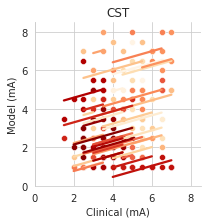

In [16]:
# CST
import pingouin as pg

rm = pg.rm_corr(data=df_clinical_model_CST, x='mA', y='mA_model', subject='ID')
print(rm)

plt.rc('font', size=10)
g = pg.plot_rm_corr(data=df_clinical_model_CST, x='mA', y='mA_model', subject='ID', kwargs_facetgrid=dict(palette='OrRd') )
plt.xlim([0, 8.5])
plt.ylim([0, 8.5])

plt.xlabel('Clinical (mA)')
plt.ylabel('Model (mA)')
plt.title('CST')

#plt.legend(title='Lead', bbox_to_anchor=(1.05, 2), loc='upper left', borderaxespad=0)

plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/rm_corr_CST.png', dpi=300, bbox_inches='tight')

In [17]:
# Pearson
import scipy.stats as stats
r = stats.pearsonr(df_clinical_model_CST['mA'], df_clinical_model_CST['mA_model'])
print(r) # (pearson, p)

(0.301585209201289, 5.107142735854408e-07)


In [18]:
# edited plot function to modify scatter plot
def plot_rm_corr_ed(data=None, x=None, y=None, subject=None, legend=False,
                 kwargs_facetgrid=dict(height=4, aspect=1), color_l=None, color_p=None):

    # Check that stasmodels is installed
    from pingouin.utils import _is_statsmodels_installed
    _is_statsmodels_installed(raise_error=True)
    from statsmodels.formula.api import ols

    # Safety check (duplicated from pingouin.rm_corr)
    assert isinstance(data, pd.DataFrame), 'Data must be a DataFrame'
    assert x in data.columns, 'The %s column is not in data.' % x
    assert y in data.columns, 'The %s column is not in data.' % y
    assert data[x].dtype.kind in 'bfiu', '%s must be numeric.' % x
    assert data[y].dtype.kind in 'bfiu', '%s must be numeric.' % y
    assert subject in data.columns, 'The %s column is not in data.' % subject
    if data[subject].nunique() < 3:
        raise ValueError('rm_corr requires at least 3 unique subjects.')

    # Remove missing values
    data = data[[x, y, subject]].dropna(axis=0)

    # Calculate rm_corr
    # rmc = pg.rm_corr(data=data, x=x, y=y, subject=subject)

    # Fit ANCOVA model
    # https://patsy.readthedocs.io/en/latest/builtins-reference.html
    # C marks the data as categorical
    # Q allows to quote variable that do not meet Python variable name rule
    # e.g. if variable is "weight.in.kg" or "2A"
    formula = "Q('%s') ~ C(Q('%s')) + Q('%s')" % (y, subject, x)
    model = ols(formula, data=data).fit()

    # Fitted values
    data['pred'] = model.fittedvalues

    # Define color palette
    #if 'palette' not in kwargs_facetgrid:
     #   kwargs_facetgrid['palette'] = sns.hls_palette(data[subject].nunique())

    # Start plot
    g = sns.FacetGrid(data, hue=subject, **kwargs_facetgrid)
    g = g.map(sns.regplot, x, "pred", scatter=False, ci=None, truncate=True, color=color_l)
    g = g.map(sns.scatterplot, x, y, alpha=1, color=color_p)

    if legend:
        g.add_legend()

    return g

               r  dof     pval          CI95%    power
rm_corr  0.15277  130  0.08033  [-0.02, 0.32]  0.41867


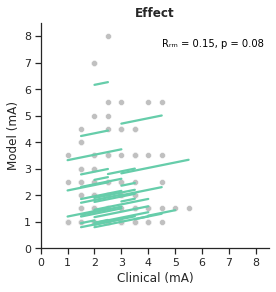

In [19]:
# HDP
import pingouin as pg
rm_HDP = pg.rm_corr(data=df_clinical_model_HDP, x='mA', y='mA_model', subject='ID')
print(rm_HDP)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

rm = plot_rm_corr_ed(data=df_clinical_model_HDP, x='mA', y='mA_model', subject='ID', color_l = 'mediumaquamarine',
color_p = 'silver')

plt.xlim([0, 8.5])
plt.ylim([0, 8.5])
xticks = np.arange(0,9,1)
plt.xticks(xticks)

plt.xlabel('Clinical (mA)')
plt.ylabel('Model (mA)')
plt.title('Effect', {'weight':'heavy'})

plt.text(4.5,7.6, u'R\u1D63\u2098 = ' + str(round(rm_HDP.loc['rm_corr']['r'],2)) + ', p = ' + str(round(rm_HDP.loc['rm_corr']['pval'],2)), {'color':'black', 'size':10})

plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/rm_corr_HDP.png', dpi=300, bbox_inches='tight')

                r  dof      pval         CI95%     power
rm_corr  0.278955  226  0.000019  [0.15, 0.39]  0.990534


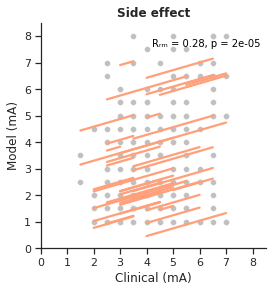

In [20]:
# CST
import pingouin as pg
rm_CST = pg.rm_corr(data=df_clinical_model_CST, x='mA', y='mA_model', subject='ID')
print(rm_CST)

rm = plot_rm_corr_ed(data=df_clinical_model_CST, x='mA', y='mA_model', subject='ID', color_l = 'lightsalmon', color_p = 'silver')

plt.xlim([0, 8.5])
plt.ylim([0, 8.5])
plt.ylim([0, 8.5])
xticks = np.arange(0,9,1)
plt.xticks(xticks)

plt.xlabel('Clinical (mA)')
plt.ylabel('Model (mA)')
plt.title('Side effect', {'weight':'heavy'})

plt.text(4.2,7.6, u'R\u1D63\u2098 = ' + str(round(rm_CST.loc['rm_corr']['r'],2)) + ', p = ' + str(round(rm_CST.loc['rm_corr']['pval'],5)), {'color':'black', 'size':10})

plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/rm_corr_CST.png', dpi=300, bbox_inches='tight')

### Linear regression

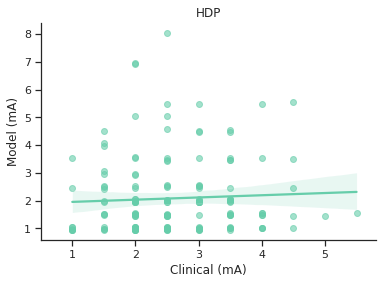

In [21]:
import seaborn as sns

ax = sns.regplot(data=df_clinical_model_HDP, x='mA', y='mA_model', y_jitter=.07, scatter_kws={'alpha':0.6}, color='mediumaquamarine' )

plt.xlim([0.5, 5.8])
#plt.ylim([0, 8.5])

plt.xlabel('Clinical (mA)')
plt.ylabel('Model (mA)')
plt.title('HDP')
plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/regplot_HDP.png', dpi=300, bbox_inches='tight')

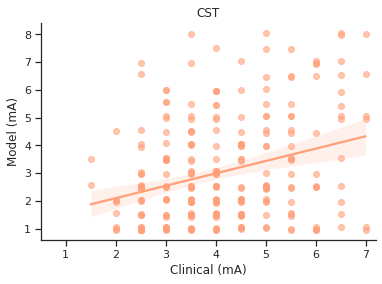

In [22]:
import seaborn as sns

ax = sns.regplot(data=df_clinical_model_CST, x='mA', y='mA_model', y_jitter=.07, scatter_kws={'alpha':0.6}, color='lightsalmon')

plt.xlim([0.5, 7.2])
#plt.ylim([0, 8.5])

plt.xlabel('Clinical (mA)')
plt.ylabel('Model (mA)')
plt.title('CST')

plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/regplot_CST.png', dpi=300, bbox_inches='tight')